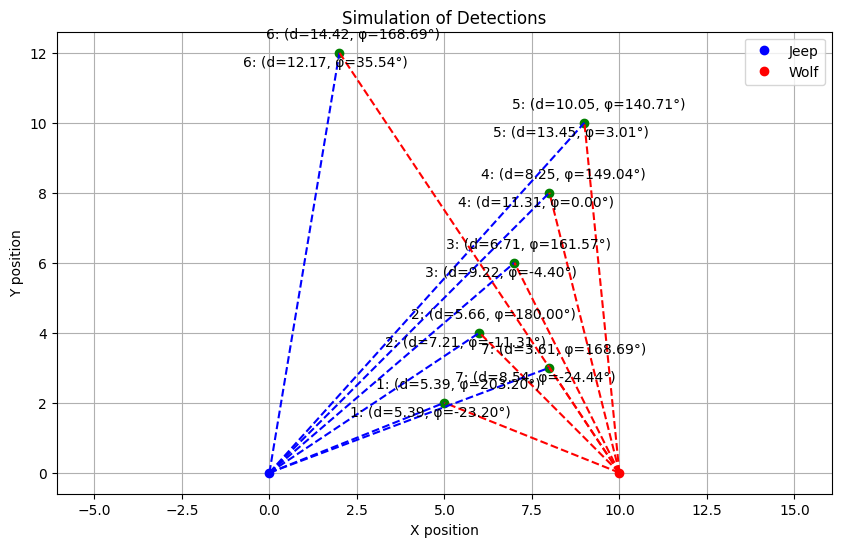

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate range and bearing from a robot to the person
def calculate_detections(robot_pos, person_pos):
    dx = person_pos[0] - robot_pos[0]
    dy = person_pos[1] - robot_pos[1]
    range_ = np.sqrt(dx**2 + dy**2)
    bearing = np.arctan2(dy, dx) - robot_pos[2] # robot_pos[2] is the orientation of the robot
    return range_, bearing

# True positions of the robots (x, y, orientation)
robot_jeep_pos = np.array([0, 0, np.radians(45)]) # Assuming Jeep is at the origin facing 45 degrees
robot_wolf_pos = np.array([10, 0, np.radians(-45)]) # Assuming Wolf is 10 units to the right of Jeep facing -45 degrees

# Sample positions of the person in front of the robots
person_positions = [np.array([5, 2]), np.array([6, 4]), np.array([7, 6]), np.array([8, 8]), np.array([9, 10]), np.array([2, 12]), np.array([8, 3])]

# Simulate detections for each position of the person
jeep_detections = [calculate_detections(robot_jeep_pos, pos) for pos in person_positions]
wolf_detections = [calculate_detections(robot_wolf_pos, pos) for pos in person_positions]

# Plotting
plt.figure(figsize=(10, 6))
# Plot the robots
plt.plot(robot_jeep_pos[0], robot_jeep_pos[1], 'bo', label='Jeep')
plt.plot(robot_wolf_pos[0], robot_wolf_pos[1], 'ro', label='Wolf')

# Plot the person's positions
for pos in person_positions:
    plt.plot(pos[0], pos[1], 'go')

# Annotate detections from Jeep
for i, (r, b) in enumerate(jeep_detections):
    plt.annotate(f'{i+1}: (d={r:.2f}, φ={np.degrees(b):.2f}°)',
                 (person_positions[i][0], person_positions[i][1]),
                 textcoords="offset points", xytext=(-10,-10), ha='center')

# Annotate detections from Wolf
for i, (r, b) in enumerate(wolf_detections):
    plt.annotate(f'{i+1}: (d={r:.2f}, φ={np.degrees(b):.2f}°)',
                 (person_positions[i][0], person_positions[i][1]),
                 textcoords="offset points", xytext=(10,10), ha='center')

# Draw lines for better visualization of detections
for pos in person_positions:
    plt.plot([robot_jeep_pos[0], pos[0]], [robot_jeep_pos[1], pos[1]], 'b--')
    plt.plot([robot_wolf_pos[0], pos[0]], [robot_wolf_pos[1], pos[1]], 'r--')

plt.axis('equal')
plt.legend()
plt.grid(True)
plt.xlabel('X position')
plt.ylabel('Y position')
plt.title('Simulation of Detections')
plt.show()


In [7]:
from scipy.optimize import least_squares

# Assuming we have the following true hidden variables which we want to estimate:
true_D = 10 # The true distance between the robots
true_theta1 = np.radians(45) # The true bearing of Jeep
true_theta2 = np.radians(-45) # The true bearing of Wolf

# The error function that calculates the difference between the observed and predicted measurements
def error_function(hidden_variables, detections_jeep, detections_wolf, robot_jeep_pos, robot_wolf_pos):
    D, theta1, theta2 = hidden_variables
    errors = []
    for (range_jeep, bearing_jeep), (range_wolf, bearing_wolf) in zip(detections_jeep, detections_wolf):
        # Predict the person's position from Jeep's detection
        predicted_x_jeep = robot_jeep_pos[0] + range_jeep * np.cos(bearing_jeep + theta1)
        predicted_y_jeep = robot_jeep_pos[1] + range_jeep * np.sin(bearing_jeep + theta1)
        
        # Predict the person's position from Wolf's detection
        predicted_x_wolf = robot_wolf_pos[0] + D + range_wolf * np.cos(bearing_wolf + theta2)
        predicted_y_wolf = robot_wolf_pos[1] + range_wolf * np.sin(bearing_wolf + theta2)
        
        # The error is the distance between the two predicted positions
        error_x = predicted_x_jeep - predicted_x_wolf
        error_y = predicted_y_jeep - predicted_y_wolf
        
        errors.extend([error_x, error_y])
        
    return errors

# Initial guesses for the hidden variables
initial_guess = [9, np.radians(40), np.radians(-40)] # D, theta1, theta2

# Perform least squares optimization
result = least_squares(
    error_function, initial_guess,
    args=(jeep_detections, wolf_detections, robot_jeep_pos, robot_wolf_pos)
)

# The optimized hidden variables
optimized_D, optimized_theta1, optimized_theta2 = result.x

# Let's print the results
optimized_D, np.degrees(optimized_theta1), np.degrees(optimized_theta2), result.success


(-2.796296633880821e-16, 45.0, -44.99999999999999, True)

In [8]:
from scipy.optimize import least_squares

# Given the known positions of the robots and the detections, this function calculates the errors
# based on the current estimates of the hidden variables.
def error_function(hidden_variables, robot_jeep_pos, robot_wolf_pos, detections):
    # Unpack hidden variables
    D, theta1, theta2 = hidden_variables
    
    # Calculate estimated positions of the robots
    est_robot_wolf_pos = np.array([robot_jeep_pos[0] + D * np.cos(theta1),
                                   robot_jeep_pos[1] + D * np.sin(theta1),
                                   theta2])

    errors = []
    # Calculate the error for each detection
    for det in detections:
        person_pos, jeep_d, jeep_phi, wolf_d, wolf_phi = det
        
        # Calculate the simulated detections for both robots
        sim_jeep_d, sim_jeep_phi = calculate_detections(robot_jeep_pos, person_pos)
        sim_wolf_d, sim_wolf_phi = calculate_detections(est_robot_wolf_pos, person_pos)
        
        # Calculate the difference between the simulated and actual detections
        jeep_error_d = sim_jeep_d - jeep_d
        jeep_error_phi = sim_jeep_phi - jeep_phi
        wolf_error_d = sim_wolf_d - wolf_d
        wolf_error_phi = sim_wolf_phi - wolf_phi
        
        # Append errors to the list
        errors.extend([jeep_error_d, jeep_error_phi, wolf_error_d, wolf_error_phi])
    
    return errors

# True hidden variables
true_D = np.linalg.norm(robot_wolf_pos[:2] - robot_jeep_pos[:2])
true_theta1 = np.arctan2(robot_wolf_pos[1] - robot_jeep_pos[1], robot_wolf_pos[0] - robot_jeep_pos[0])
true_theta2 = robot_wolf_pos[2]

# Prepare the detections data for the optimization
# Each element in the list is a tuple: (person_position, jeep_range, jeep_bearing, wolf_range, wolf_bearing)
detections_data = [
    (pos, *jeep_det, *wolf_det) for pos, jeep_det, wolf_det in zip(person_positions, jeep_detections, wolf_detections)
]

# Initial guess for the hidden variables
initial_guess = [9, np.radians(40), np.radians(-40)]  # Slightly wrong initial guess to simulate the real situation

# Perform least squares optimization
result = least_squares(error_function, initial_guess, args=(robot_jeep_pos, robot_wolf_pos, detections_data))

# The estimated hidden variables
estimated_D, estimated_theta1, estimated_theta2 = result.x

# Let's print the results
print(f"True hidden variables: D={true_D:.2f}, theta1={np.degrees(true_theta1):.2f}°, theta2={np.degrees(true_theta2):.2f}°")
print(f"Estimated hidden variables: D={estimated_D:.2f}, theta1={np.degrees(estimated_theta1):.2f}°, theta2={np.degrees(estimated_theta2):.2f}°")


True hidden variables: D=10.00, theta1=0.00°, theta2=-45.00°
Estimated hidden variables: D=10.00, theta1=-0.00°, theta2=-45.00°
